In [65]:
from __future__ import division
import os
import numpy as np
from collections import OrderedDict
import logging
import pandas

from astropy.io import fits
import astropy.wcs 
from astropy import table
import sep
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import astropyp
print 'astropyp version', astropyp.version.version

from IPython.display import display

logger = logging.getLogger('ipy_session')
logger.setLevel(logging.INFO)
img_path = '/media/data-beta/users/fmooleka/decam/std_resamp/'
conv_filter = np.array([
    [0.030531, 0.065238, 0.112208, 0.155356, 0.173152, 0.155356, 0.112208, 0.065238, 0.030531],
    [0.065238, 0.139399, 0.239763, 0.331961, 0.369987, 0.331961, 0.239763, 0.139399, 0.065238],
    [0.112208, 0.239763, 0.412386, 0.570963, 0.636368, 0.570963, 0.412386, 0.239763, 0.112208],
    [0.155356, 0.331961, 0.570963, 0.790520, 0.881075, 0.790520, 0.570963, 0.331961, 0.155356],
    [0.173152, 0.369987, 0.636368, 0.881075, 0.982004, 0.881075, 0.636368, 0.369987, 0.173152],
    [0.155356, 0.331961, 0.570963, 0.790520, 0.881075, 0.790520, 0.570963, 0.331961, 0.155356],
    [0.112208, 0.239763, 0.412386, 0.570963, 0.636368, 0.570963, 0.412386, 0.239763, 0.112208],
    [0.065238, 0.139399, 0.239763, 0.331961, 0.369987, 0.331961, 0.239763, 0.139399, 0.065238],
    [0.030531, 0.065238, 0.112208, 0.155356, 0.173152, 0.155356, 0.112208, 0.065238, 0.030531]
])
# SExtractor 'extract' detection parameters
sex_params = {
    'extract': {
        #'thresh': 1.5,# *bkg.globalrms,
        #'err':,
        #'minarea': 5, # default
        'conv': conv_filter,
        #'deblend_nthresh': 32, #default
        'deblend_cont': 0.001,
        #'clean': True, #default
        #'clean_param': 1 #default
    },
    'kron_k': 2.5,
    'kron_min_radius': 3.5,
    'filter': conv_filter,
    'thresh': 1.5
}

idx_connect = 'sqlite:////media/data-beta/users/fmooleka/decam/decam.db'
exp_connect = 'sqlite:////media/data-beta/users/fmooleka/2016decam/{0}.{1}.db'

aper_radius = 8
gain=4.
min_flux = 1000
min_amplitude = 500
subsampling = 5
good_amplitude = 100
calibrate_amplitude = 200
max_offset=3

% matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

astropyp version 0.0.dev224


In [66]:
import sep
conv_filter = np.array([
    [0.030531, 0.065238, 0.112208, 0.155356, 0.173152, 0.155356, 0.112208, 0.065238, 0.030531],
    [0.065238, 0.139399, 0.239763, 0.331961, 0.369987, 0.331961, 0.239763, 0.139399, 0.065238],
    [0.112208, 0.239763, 0.412386, 0.570963, 0.636368, 0.570963, 0.412386, 0.239763, 0.112208],
    [0.155356, 0.331961, 0.570963, 0.790520, 0.881075, 0.790520, 0.570963, 0.331961, 0.155356],
    [0.173152, 0.369987, 0.636368, 0.881075, 0.982004, 0.881075, 0.636368, 0.369987, 0.173152],
    [0.155356, 0.331961, 0.570963, 0.790520, 0.881075, 0.790520, 0.570963, 0.331961, 0.155356],
    [0.112208, 0.239763, 0.412386, 0.570963, 0.636368, 0.570963, 0.412386, 0.239763, 0.112208],
    [0.065238, 0.139399, 0.239763, 0.331961, 0.369987, 0.331961, 0.239763, 0.139399, 0.065238],
    [0.030531, 0.065238, 0.112208, 0.155356, 0.173152, 0.155356, 0.112208, 0.065238, 0.030531]
])

# SExtractor 'extract' detection parameters
sex_params = {
    'extract': {
        #'thresh': 50, #*bkg.globalrms,
        #'err':,
        #'minarea': 5, # default
        'conv': conv_filter,
        #'deblend_nthresh': 32, #default
        'deblend_cont': 0.001,
        #'clean': True, #default
        #'clean_param': 1 #default
    },
    'kron_k': 2.5,
    'kron_min_radius': 3.5,
    'filter': conv_filter,
    'thresh': 1.5
}

expnum = 442493
sql = 'select * from decam_obs where EXPNUM={0}'.format(expnum)
exp_info = astropyp.db_utils.index.query(sql, idx_connect)
filename = exp_info[exp_info['PRODTYPE']=='image']['filename'][0]
img = fits.open(filename)

filename = exp_info[exp_info['PRODTYPE']=='dqmask']['filename'][0]
dqmask = fits.open(filename)

img_data = img[1].data
dqmask_data = dqmask[1].data

ccd = astropyp.phot.phot.SingleImage(img=img_data, dqmask=dqmask_data, gain=4., exptime=30, aper_radius=8)
ccd.detect_sources(sex_params, subtract_bkg=True)
ccd.select_psf_sources(min_flux, min_amplitude, edge_dist=aper_radius+max_offset)
psf_array = ccd.create_psf()
#ccd.show_psf()
good_idx = ccd.catalog.sources['peak']>calibrate_amplitude
good_idx = good_idx & (ccd.catalog.sources['pipeline_flags']==0)
result = ccd.perform_psf_photometry(indices=good_idx)

INFO:astropyp.phot.psf:Total sources: 489
INFO:astropyp.phot.psf:Sources with low flux: 113
INFO:astropyp.phot.psf:Sources with low amplitude: 395
INFO:astropyp.phot.psf:Sources with bad pixels: 178
INFO:astropyp.phot.psf:Elliptical sources: 91
INFO:astropyp.phot.psf:Source with close neighbors: 60
INFO:astropyp.phot.psf:Sources near an edge: 84
INFO:astropyp.phot.psf:Sources after cuts: 44


In [67]:
print 'good sources', np.sum(good_idx)
print 'good psf_err', np.sum(np.isfinite(ccd.catalog.sources['psf_mag_err']))

good sources 86
good psf_err 86


In [68]:
good_idx = ccd.catalog.sources['peak']>calibrate_amplitude
good_idx = good_idx & (ccd.catalog.sources['pipeline_flags']==0)
good_idx = good_idx & np.isfinite(ccd.catalog.sources['psf_mag'])
good_sources = ccd.catalog.sources[good_idx]

print 'rms', np.sqrt(np.sum(good_sources['psf_mag_err']**2/len(good_sources)))
print 'mean', np.mean(good_sources['psf_mag_err'])
print 'median', np.median(good_sources['psf_mag_err'])
print 'stddev', np.std(good_sources['psf_mag_err'])

bad_count = np.sum(good_sources['psf_mag_err']>.05)
print 'bad psf error: {0}, or {1}%'.format(bad_count, bad_count/len(good_sources)*100)
print 'Better than 5%: {0} of {1}'.format(np.sum(good_sources['psf_mag_err']<=.05), len(good_sources))
print 'Better than 2%: {0} of {1}'.format(np.sum(good_sources['psf_mag_err']<=.02), len(good_sources))
good_sources['aper_flux','psf_flux','peak','psf_mag_err'][good_sources['psf_mag_err']>.05]

rms 0.0218020244543
mean 0.0145499591263
median 0.0103483910609
stddev 0.0162365932305
bad psf error: 3, or 3.48837209302%
Better than 5%: 83 of 86
Better than 2%: 66 of 86


aper_flux,psf_flux,peak,psf_mag_err
float64,float64,float64,float64
11612.4494165,13415.3190456,597.742126465,0.0508443801306
163992.750059,166485.893865,6473.95556641,0.0776251275243
10643.6731989,10466.0743569,373.162811279,0.114393727525


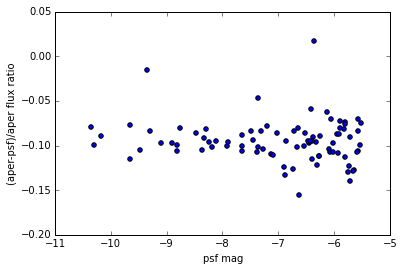

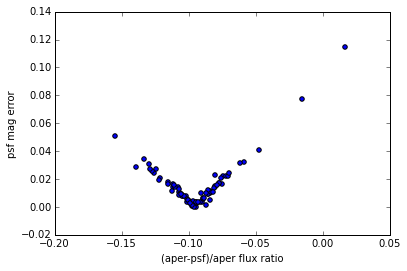

In [69]:
flux_diff = (good_sources['aper_flux']-good_sources['psf_flux'])/good_sources['aper_flux']
plt.scatter(good_sources['psf_mag'],flux_diff)
plt.xlabel('psf mag')
plt.ylabel('(aper-psf)/aper flux ratio')
plt.show()

plt.scatter(flux_diff, good_sources['psf_mag_err'],)
plt.xlabel('(aper-psf)/aper flux ratio')
plt.ylabel('psf mag error')
plt.show()

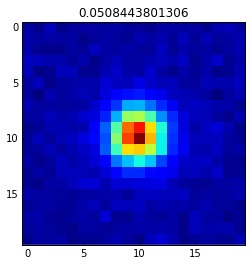

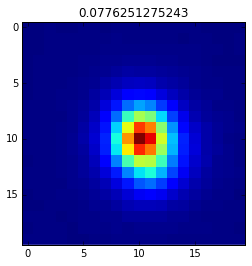

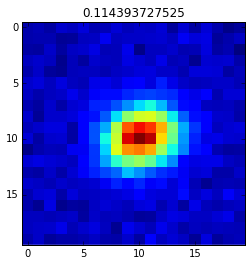

In [70]:
# We see that all sources with high psf error are actually bad detections
# or sources with potential unresolved companions
from astropy.nddata.utils import extract_array
bad_idx = good_sources['psf_mag_err']>.05
for src in good_sources[bad_idx]:
    subset = extract_array(img_data, (20,20), (src['y'],src['x']))
    plt.imshow(subset, interpolation='none')
    plt.title(src['psf_mag_err'])
    plt.show()

In [71]:
good_idx = ((ccd.catalog.sources['peak']>calibrate_amplitude)
    & (ccd.catalog.sources['pipeline_flags']==0)
    & np.isfinite(ccd.catalog.sources['psf_mag'])
    & (ccd.catalog.sources['psf_mag_err']<.05))
good_sources = ccd.catalog.sources[good_idx]

print 'rms', np.sqrt(np.sum(good_sources['psf_mag_err']**2/len(good_sources)))
print 'mean', np.mean(good_sources['psf_mag_err'])
print 'median', np.median(good_sources['psf_mag_err'])
print 'stddev', np.std(good_sources['psf_mag_err'])

rms 0.015202050803
mean 0.0121497981889
median 0.010016770262
stddev 0.00913699910179
